In [681]:
# JBY: Set up env using "ipython --pylab" imports
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/jason/virtualenvs/default/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [682]:
%autoreload 2

In [683]:
interactive = False
if interactive:
    %matplotlib osx
else:
    %matplotlib inline
figsize(17,6)
rcParams['font.size'] = 18

In [684]:
import pandas as pd
import json
import os

#from pyextra import looser

# Misc functions

## Load some functions from helper.py

In [1351]:
from helper import colors, primary_tags, primary_tag_set, primary_tags_carbonplan_pt_order, get_pt, get_clr
from helper import DuckStruct, lsprint

## Define some functions here

In [1352]:
def display_full(df):
    with pd.option_context('display.max_columns', 2000), pd.option_context('display.max_colwidth', -1):
        display(df)

In [1353]:
def savefigs(name):
    savefig('%s.png' % name)
    savefig('%s.pdf' % name)

# Load data

In [1354]:
first_year = 2020
last_year = 2035
n_years = last_year - first_year + 1       # 16 years from 2020 - 2035, inclusive

In [1355]:
with open(os.path.join(os.getcwd(), '..', 'data', 'Supply_Cost_Projections_df.csv'), 'r') as ff:
    df = pd.read_csv(ff)

In [1356]:
#df = pd.json_normalize(whole_json['projects'])

In [1357]:
df.shape

(191, 116)

In [1358]:
#df.head()

Fix some CSV issues that were not present with the initial JSON version

In [1359]:
# Convert from string like "['forests', 'reforestation']" to list of strings
df.tags = df.tags.map(lambda x: json.loads(x.replace("'", '"')))

## Clean and standardize cost and volume data

In [1360]:
# Just leave them as nans!
##df.fillna('', inplace=True)

If cost is provided in cost_2020_min column, take it as valid.

If cost is provided in cost_value column AND the cost_rating is not -9999, copy to cost_2020_min colum and mark as valid.

Note that this rules out two MS Forest projects that have a cost but where it is marked as -9999 (unless someone researches those options and enters their evaluation of the cost in cost_2020_min)

In [1361]:
selector_copy_from_cost_val = (df.cost_value.map(bool) & 
                               (df.cost_rating != -9999) & 
                               (df.cost_2020_min.isna()))
df.loc[selector_copy_from_cost_val, 'cost_2020_min'] = df[selector_copy_from_cost_val].cost_value
df['valid_cost'] = df.cost_2020_min.notna()

In [1362]:
#selector_copy_from_cost_val = (df.cost_value.map(bool) & 
#                               (df.cost_rating != -9999) & 
#                               (df.cost_2020_min == ''))
#df.loc[selector_copy_from_cost_val, 'cost_2020_min'] = df[selector_copy_from_cost_val].cost_value
#df['valid_cost'] = (df.cost_2020_min != '')

Ditto for volume

In [1363]:
selector_copy_from_volume_val = (df.volume_value.map(bool) & 
                                (df.volume_rating != -9999) & 
                                (df.vol_2020_min.isna()))
df.loc[selector_copy_from_volume_val, 'vol_2020_min'] = df[selector_copy_from_volume_val].volume_value
df['valid_volume'] = df.vol_2020_min.notna()

Mark those rows with valid volume and cost. Only these will be plotted later

In [1364]:
df['valid_vc'] = (df['valid_volume'] & df['valid_cost'])

If cost_2020_max and/or vol_2020_max are not filled in, copy from mins

In [1365]:
selector_copy_cost_min_to_max = (df.cost_2020_min.notna() & df.cost_2020_max.isna())
df.loc[selector_copy_cost_min_to_max, 'cost_2020_max'] = df.cost_2020_min

In [1366]:
selector_copy_vol_min_to_max = (df.vol_2020_min.notna() & df.vol_2020_max.isna())
df.loc[selector_copy_vol_min_to_max, 'vol_2020_max'] = df.vol_2020_min

In [1367]:
assert (df[df.valid_vc].cost_2020_max >= df[df.valid_vc].cost_2020_min).all(), 'Error: max < min'
assert (df[df.valid_vc].vol_2020_max >= df[df.valid_vc].vol_2020_min).all(), 'Error: max < min'

In [1368]:
def basic_checks(just_first_year=False):
    _last_year = first_year if just_first_year else last_year
    for year in range(first_year, _last_year + 1):
        assert df[df.valid_vc]['cost_%s_min' % year].notnull().all(), year
        assert df[df.valid_vc]['cost_%s_max' % year].notnull().all(), year
        assert df[df.valid_vc]['vol_%s_min' % year].notnull().all(), year
        assert df[df.valid_vc]['vol_%s_max' % year].notnull().all(), year
        assert (df[df.valid_vc]['cost_%s_max' % year] >= df[df.valid_vc]['cost_%s_min' % year]).all(), year
        assert (df[df.valid_vc]['vol_%s_max' % year] >= df[df.valid_vc]['vol_%s_min' % year]).all(), year

In [1369]:
# Run basic checks after
basic_checks(just_first_year=True)

In [1370]:
def get_array_all_years(project, pattern):
    '''Pattern like "cost_%s_min"'''
    return array([getattr(project, pattern % year) for year in range(first_year, last_year + 1)])

def min_cost_array(project): return get_array_all_years(project, 'cost_%s_min')
def max_cost_array(project): return get_array_all_years(project, 'cost_%s_max')
def min_vol_array(project): return get_array_all_years(project, 'vol_%s_min')
def max_vol_array(project): return get_array_all_years(project, 'vol_%s_max')

def min_cost_df(project): return pd.DataFrame(get_array_all_years(project, 'cost_%s_min'))
def max_cost_df(project): return pd.DataFrame(get_array_all_years(project, 'cost_%s_max'))
def min_vol_df(project): return pd.DataFrame(get_array_all_years(project, 'vol_%s_min'))
def max_vol_df(project): return pd.DataFrame(get_array_all_years(project, 'vol_%s_max'))

def get_costs(project):
    '''Return average costs for all years'''
    #c_min = array([getattr(project, 'cost_%s_min' % year) for year in range(first_year, last_year + 1)])
    #c_max = array([getattr(project, 'cost_%s_max' % year) for year in range(first_year, last_year + 1)])    
    return (min_cost_array(project) + max_cost_array(project)) / 2

def get_vols(project):
    '''Return average volumes for all years'''
    #v_min = array([getattr(project, 'vol_%s_min' % year) for year in range(first_year, last_year + 1)])
    #v_max = array([getattr(project, 'vol_%s_max' % year) for year in range(first_year, last_year + 1)])    
    return (min_vol_array(project) + max_vol_array(project)) / 2

In [1371]:
def write_yearly_data_to_df(df, idx, yearly_data_array, pattern):
    '''Writes the data in yearly_data_array back to df at the given row index and
    for all years to the columns described by pattern.
    Ugly, but 🤷‍♂️'''
    
    assert len(yearly_data_array) == n_years, 'Wrong length data'
    for ii, year in enumerate(range(first_year, last_year + 1)):
        df.at[idx, pattern % year] = yearly_data_array[ii]

Interpolate any missing data exponentially in time. Uses [pandas.DataFrame.interpolate](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)

In [1372]:
def exponential_interpolate(df):
    for project in df.itertuples():
        if not project.valid_vc:
            continue
        #print(project.Index)
        
        tmp = exp(log(min_cost_df(project)).interpolate()).to_numpy()
        write_yearly_data_to_df(df, project.Index, tmp, 'cost_%s_min')

        tmp = exp(log(max_cost_df(project)).interpolate()).to_numpy()
        write_yearly_data_to_df(df, project.Index, tmp, 'cost_%s_max')

        tmp = exp(log(min_vol_df(project)).interpolate()).to_numpy()
        write_yearly_data_to_df(df, project.Index, tmp, 'vol_%s_min')

        tmp = exp(log(max_vol_df(project)).interpolate()).to_numpy()
        write_yearly_data_to_df(df, project.Index, tmp, 'vol_%s_max')
                
        #write_min_costs(min_costs)

In [1373]:
exponential_interpolate(df)

Make non-null volumes at least 10 to avoid very low values on log-scale volume plots. Make max always at least as large as min.

In [1374]:
for year in range(first_year, last_year + 1):
    # 1. Make non-null volumes at least 10 to avoid very low values on log-scale volume plots.
    col = 'vol_%s_max' % year
    sel = df.valid_vc & df[col].notna() & (df[col] < 10.0)
    df.loc[sel, col] = 10.0
    
    # 2. Make max always at least as large as min and fill max in with min if it's blank
    
    # Copy any min cost to max if max is less or nan
    min_col, col = ('cost_%s_min' % year), ('cost_%s_max' % year)
    sel = df.valid_vc & (~(df[col] > df[min_col]))
    df.loc[sel, col] = df.loc[sel, min_col]

    # Copy any min vol to max if max is less or nan
    min_col, col = ('vol_%s_min' % year), ('vol_%s_max' % year)
    sel = df.valid_vc & (~(df[col] > df[min_col]))
    df.loc[sel, col] = df.loc[sel, min_col]

Run some basic checks

In [1375]:
# Run basic checks after
basic_checks()

## Other cleaning and standardization

Flatten tags for easier filtering

In [1376]:
tagset = set()
for tags in df.tags:
    for tag in tags:
        tagset.add(tag)
taglist = sorted(list(tagset))

In [1377]:
# Create boolean field for each tag, e.g. t_dac and t_ocean
for tag in taglist:
    df['t_%s' % tag] = df.tags.map(lambda x: tag in x)
# n_tags
df['n_tags'] = df.tags.map(len)

In [1378]:
#df.head()

If pt is missing, fill in from tags column

In [1379]:
sel = df.pt.isna()
df.loc[sel, 'pt'] = df.tags.map(get_pt)

Extract different aggregation groups

In [1380]:
projection_groups = {}
print('Available projection groups by primary tag:')
for pt in primary_tags:
    projection_groups[pt] = list(df[df.pt == pt].projection_group.unique())
    print('%16s: %s' % (pt, projection_groups[pt]))

Available projection groups by primary tag:
         forests: ['company', 'aggregate']
            soil: ['company', 'aggregate']
         biomass: ['company']
           ocean: ['company']
  mineralization: ['company', 'aggregate']
             dac: ['company']


In [1381]:
# Get selector the prefers "aggregate" grouping but falls back to "company" if not available

sel_prefer_aggregate = False & df.valid_vc    # Initially select nothing
for pt, groups in projection_groups.items():
    which_group = 'aggregate' if 'aggregate' in groups else 'company'
    sel_this = (df.pt == pt) & (df.projection_group == which_group)
    print('%16s: selected %3d entries from group %s' % (pt, sel_this.sum(), which_group))
    sel_prefer_aggregate |= sel_this

         forests: selected   2 entries from group aggregate
            soil: selected   2 entries from group aggregate
         biomass: selected  29 entries from group company
           ocean: selected   5 entries from group company
  mineralization: selected   2 entries from group aggregate
             dac: selected   4 entries from group company


In [1382]:
assert set(primary_tags_carbonplan_pt_order) == primary_tag_set, 'Set of primary tags must be the same!'
print('Primary tags in plot order:\n', primary_tags)
print('Primary tags in pt order:  \n', primary_tags_carbonplan_pt_order)

Primary tags in plot order:
 ['forests', 'soil', 'biomass', 'ocean', 'mineralization', 'dac']
Primary tags in pt order:  
 ['forests', 'soil', 'biomass', 'dac', 'mineralization', 'ocean']


In [1383]:
# Check that pt column is filled in correctly
assert (df.pt != df.tags.map(get_pt)).sum() == 0, 'Something went wrong'
# Add clr column
df['clr'] = df.tags.map(get_clr)

In [1384]:
# Does any project not have a primary tag?
print(((df.pt == 'none') | (df.pt.isna())).sum(), 'projects are missing a primary tag')

0 projects are missing a primary tag


# Look at data

In [1385]:
df.head(5)

,id,tags,description,applicant,rating,keywords,methods,revisions,location.name,source.name,...,t_olivine,t_phytoplankton,t_redd+,t_reforestation,t_soil,t_storage,t_wetlands,t_wood,n_tags,clr
0,STRP007,"[forests, reforestation]",Reforestation using heavy-lift drones and seed...,Droneseed,2.0,NaN,Project reports a volume of 510 tCO₂ in the fi...,"[{'date': '05-18-2020', 'note': 'First release...","WA, USA",Stripe 2020 Negative Emissions Purchase,...,False,False,False,True,False,False,False,False,2,"[0.49, 0.7, 0.42]"
1,STRP008,"[forests, reforestation]",Reforestation with verification and monitoring...,Pachama,1.0,"Rip's Redwoods, Guanare",Project directly reports rates of 16 tCO₂ / ha...,"[{'date': '05-18-2020', 'note': 'First release...","Uruguay & CA, USA",Stripe 2020 Negative Emissions Purchase,...,False,False,False,True,False,False,False,False,2,"[0.49, 0.7, 0.42]"
2,STRP012,"[forests, ifm]",Forest carbon rental markets.,SilviaTerra,3.0,NaN,This project is based on a novel forest carbon...,"[{'date': '05-18-2020', 'note': 'First release...",Southern USA,Stripe 2020 Negative Emissions Purchase,...,False,False,False,False,False,False,False,False,2,"[0.49, 0.7, 0.42]"
3,STRP013,"[forests, agroforestry]",Conversion of annual cropland to sheep/chestnu...,Breadtree Farms,1.0,NaN,Project claims a range of 56 tCO₂ to 140 tCO₂ ...,"[{'date': '05-18-2020', 'note': 'First release...","Johnsonville, NY, USA",Stripe 2020 Negative Emissions Purchase,...,False,False,False,False,False,False,False,False,2,"[0.49, 0.7, 0.42]"
4,STRP019,"[forests, reforestation]",Reforestation offset model.,Future Forest,1.0,NaN,"For a 174 ha land project in Scotland, project...","[{'date': '05-18-2020', 'note': 'First release...",Scotland,Stripe 2020 Negative Emissions Purchase,...,False,False,False,True,False,False,False,False,2,"[0.49, 0.7, 0.42]"


In [1386]:
lsprint(df.columns.to_list())

 id                  permanence_value       cost_2026_min  vol_2023_min  valid_cost       
 tags                permanence_units       cost_2027_min  vol_2024_min  valid_volume     
 description         permanence_rating      cost_2028_min  vol_2025_min  valid_vc         
 applicant           permanence_notes       cost_2029_min  vol_2026_min  t_aggregate      
 rating              permanence_comment     cost_2030_min  vol_2027_min  t_agroforestry   
 keywords            additionality_value    cost_2031_min  vol_2028_min  t_biochar        
 methods             additionality_units    cost_2032_min  vol_2029_min  t_biomass        
 revisions           additionality_rating   cost_2033_min  vol_2030_min  t_concrete       
 location.name       additionality_notes    cost_2034_min  vol_2031_min  t_conversion     
 source.name         additionality_comment  cost_2035_min  vol_2032_min  t_dac            
 source.license      cost_value             cost_2020_max  vol_2033_min  t_farming        

In [1387]:
#display_full(df.head(1))

In [1388]:
for tag in taglist:
    print('%4d: %s' % (df['t_%s' % tag].sum(), tag))

   1: aggregate
   1: agroforestry
  11: biochar
  29: biomass
   5: concrete
   6: conversion
   4: dac
  13: farming
 113: forests
  10: grazing
  40: ifm
  10: injection
   2: insulation
   2: macroalgae
  15: mineralization
   7: ocean
   4: olivine
   2: phytoplankton
   4: redd+
  63: reforestation
  29: soil
   3: storage
   1: wetlands
   6: wood


In [1389]:
#display_full(df[df.t_dac & df.t_mineralization])

# Plots

## Reproduce Carbon Plan plots

In [ ]:
# For these plots, filter just to the 'company' projection group

df_ = df[df.projection_group == 'company']

In [ ]:
figsize(18,18)
clr_handles = {tag: None for tag in primary_tags}
for ii, project in enumerate(df_.itertuples()):
    clr = project.clr
    volume = project.volume_value
    hh, = semilogx(volume, ii, 'o', mec=clr, mfc=clr, ms=15)
    clr_handles[project.pt] = hh
xlabel('Volume (tons)')
ylabel('Project ID')
legend(clr_handles.values(), clr_handles.keys())
savefigs('carbon_plan_type_vol_separate')

In [ ]:
figsize(18,4)
for ii, project in enumerate(df_.itertuples()):
    clr = project.clr
    y_coord = (-len(primary_tags)) if project.pt == 'none' else -primary_tags.index(project.pt)
    volume = project.volume_value
    semilogx(volume, y_coord, 'o', mec=clr, mfc=clr, ms=20)
xlabel('Volume (tons)')
yticks([])
tight_layout()
savefigs('carbon_plan_type_vol')

In [ ]:
figsize(18,4)
for ii, project in enumerate(df_.itertuples()):
    clr = project.clr
    y_coord = (-len(primary_tags)) if project.pt == 'none' else -primary_tags.index(project.pt)
    permanence = project.permanence_value
    semilogx(permanence, y_coord, 'o', mec=clr, mfc=clr, ms=20)
xlabel('Permanence (years)')
yticks([])
tight_layout()
savefigs('carbon_plan_type_permanence')

In [ ]:
figsize(18,4)
for ii, project in enumerate(df_.itertuples()):
    clr = project.clr
    y_coord = (-len(primary_tags)) if project.pt == 'none' else -primary_tags.index(project.pt)
    cost = project.cost_value
    semilogx(cost, y_coord, 'o', mec=clr, mfc=clr, ms=20)
xlabel('Cost ($/ton)')
yticks([])
tight_layout()
savefigs('carbon_plan_type_cost')

## Vol-vs-Cost

In [1390]:
def nice_vc_axes(skip_x=False):
    gca().yaxis.set_major_formatter('${x:1.0f}')
    if not skip_x:
        ax = axis()
        xticks(10 ** arange(3*4),
               ['1', '10', '100', '1k', '10k', '100k', '1M', '10M', '100M', '1G', '10G', '100G'])
        axis(ax)

In [1391]:
# Then: write group selector and use to filter the below plots

In [1392]:
def plot_vc_to_time(df, start=2020, end=2025, plfn=loglog, save_as=None):
    '''Plot data from first year to last year, highlighting last year.'''

    # Convert from years to slice index
    start_ii = start - first_year
    end_ii = end - first_year
    
    for ii, project in enumerate(df.itertuples()):
        #print('project is', type(project))
        clr = project.clr
        vols = get_vols(project)
        costs = get_costs(project)
        
        #plfn(vols[start_ii], costs[start_ii], 'o', mec=clr, mfc='w', ms=14)
        #plfn(vols[start_ii:end_ii+1], costs[start_ii:end_ii+1], '-', c=clr)
        plfn(vols[start_ii:end_ii+1], costs[start_ii:end_ii+1], '-o', c=clr, mec=clr, mfc='w', ms=14)
        plfn(vols[end_ii], costs[end_ii], 'o', mec=clr, mfc=clr, ms=20)
        text(vols[end_ii], costs[end_ii], '   %s' % project.applicant)
    #text(10*.7, 1000, '%s' % end)
    annotate('%s' % end, xy=(.03, .93), xycoords='axes fraction', fontsize=32)
    xlabel('Volume (tons)')
    ylabel('Cost ($/ton)')
    nice_vc_axes()
    tight_layout()
    if save_as:
        savefigs(save_as)

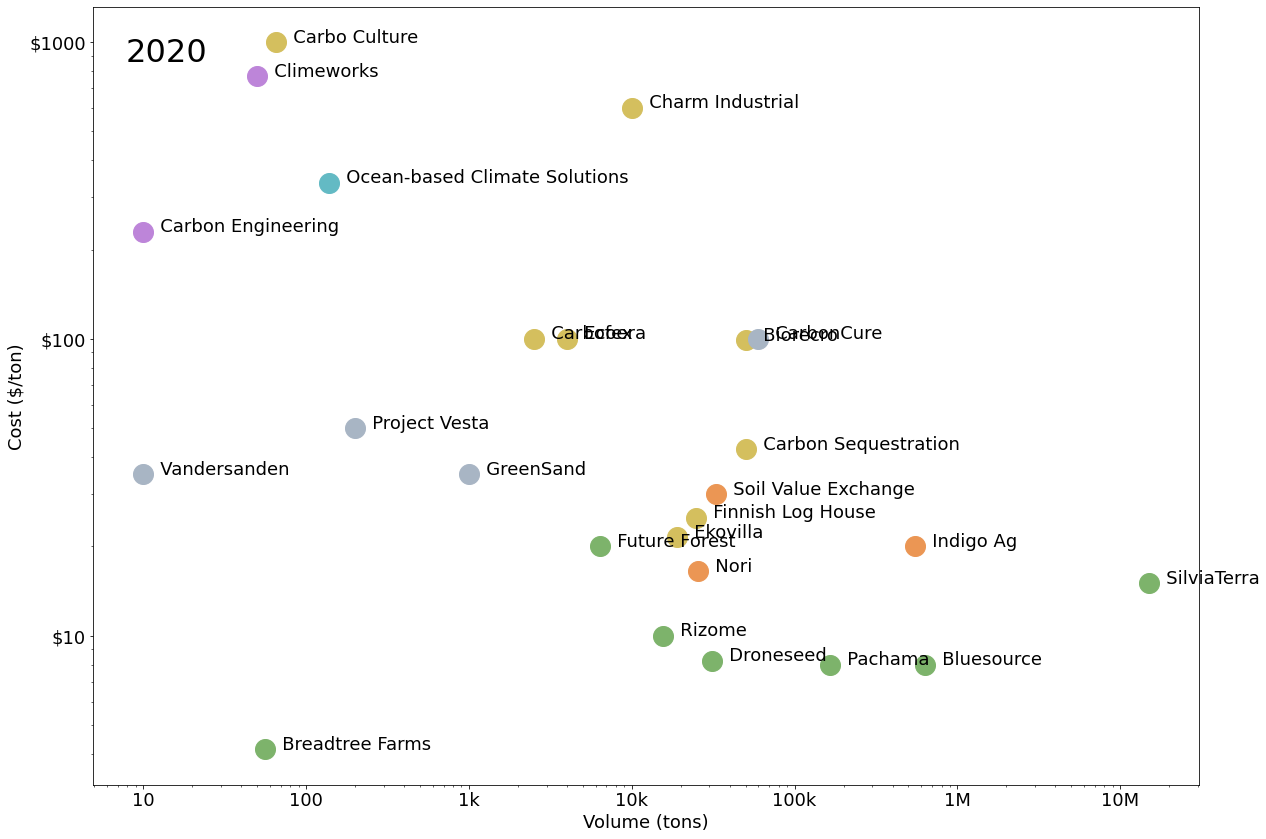

In [1393]:
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
#plot_vc_to_time(df[sel], save_as='carbon_plan_vol_cost_pt')
plot_vc_to_time(df[sel], end=2020)

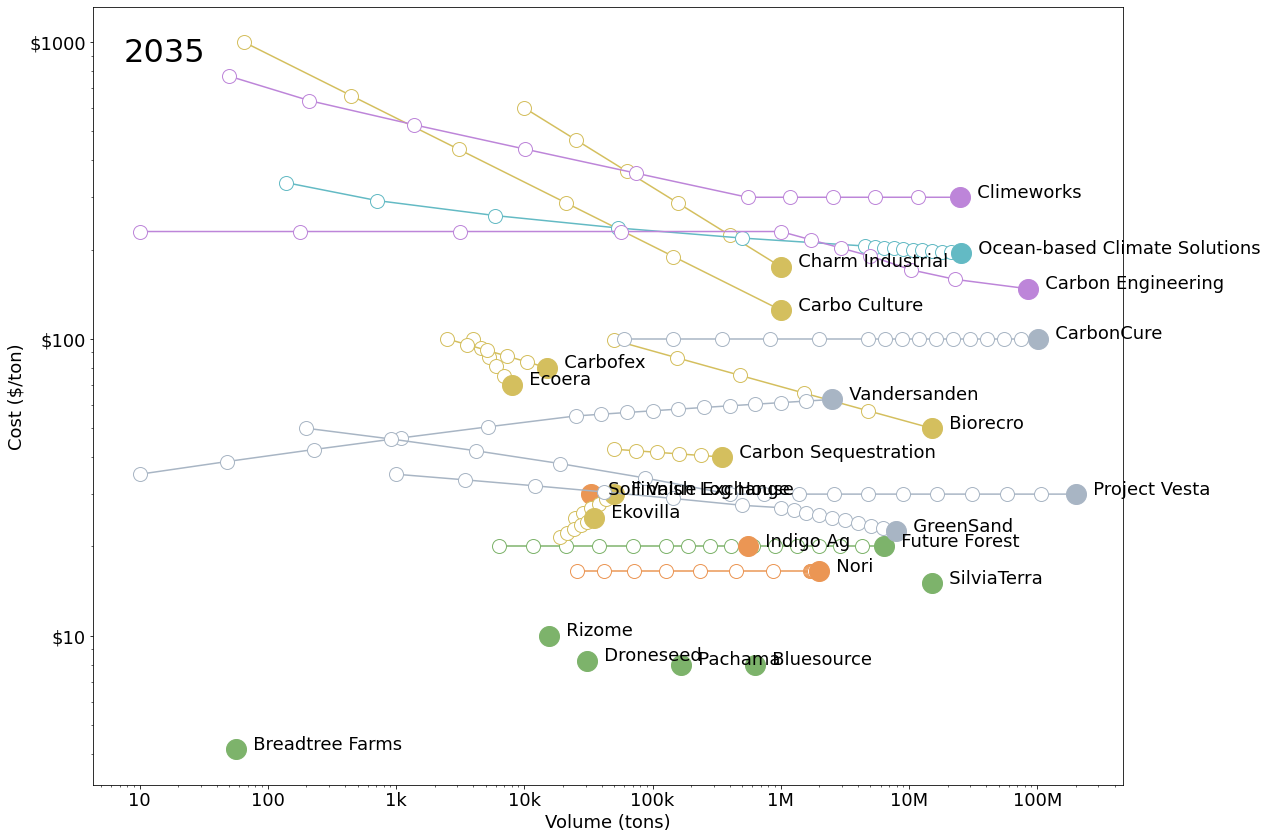

In [1394]:
# Plot data to last year
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
year = last_year
plot_vc_to_time(df[sel], end=year)

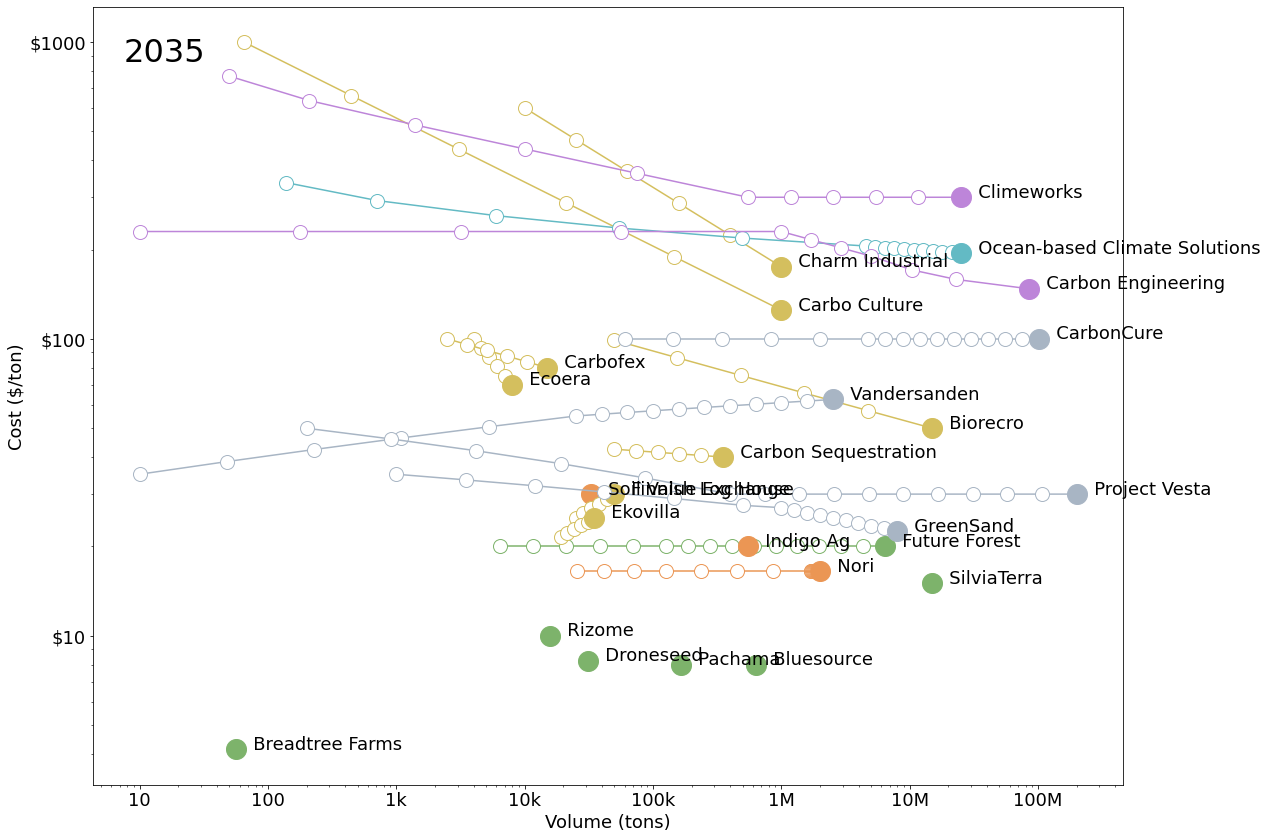

In [1343]:
# Expensive: generate each frame for animation
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
for year in range(first_year, last_year + 1):
    clf()
    plot_vc_to_time(df[sel], end=year, save_as='vol_cost_pt_y%d' % year)

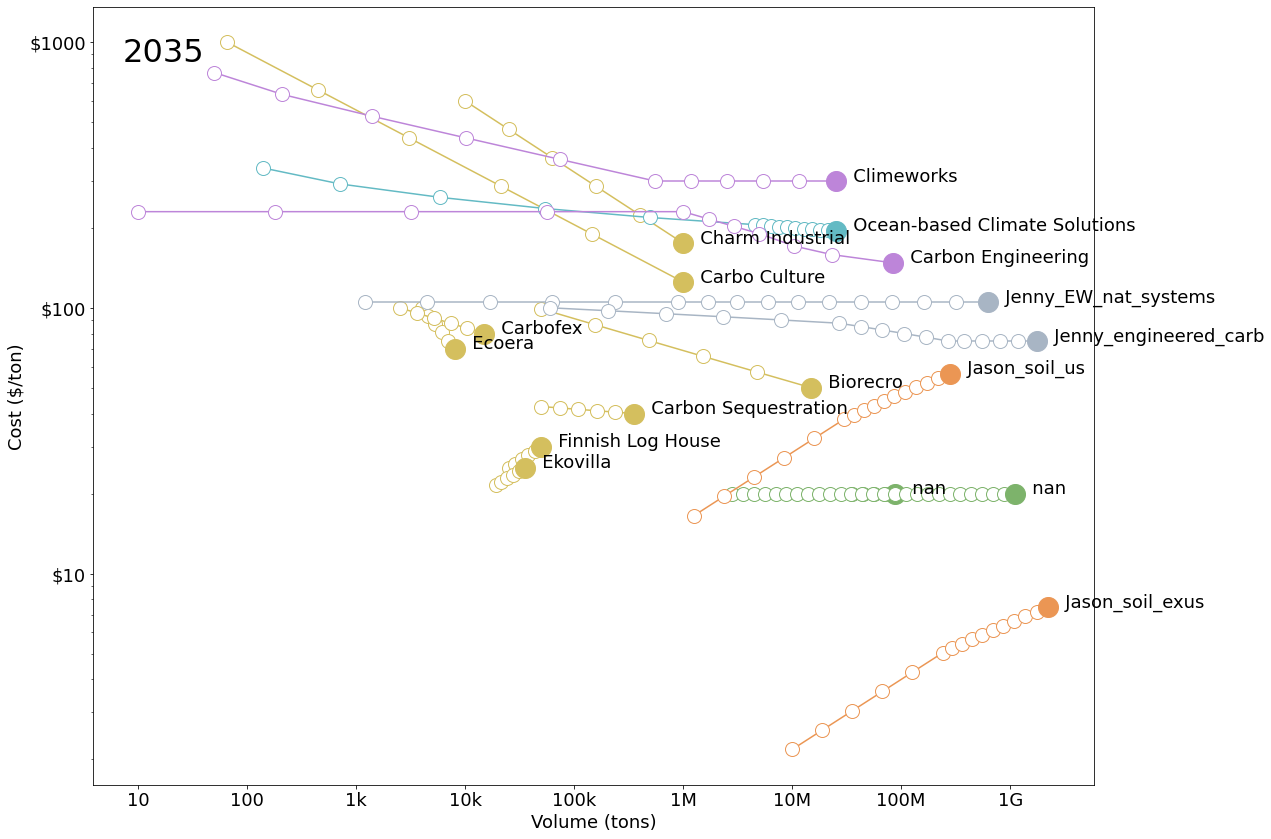

In [1395]:
# Plot data to last year. Aggregate version.
figsize(18,12)
sel = (df.valid_vc & sel_prefer_aggregate)
year = last_year
plot_vc_to_time(df[sel], end=year)

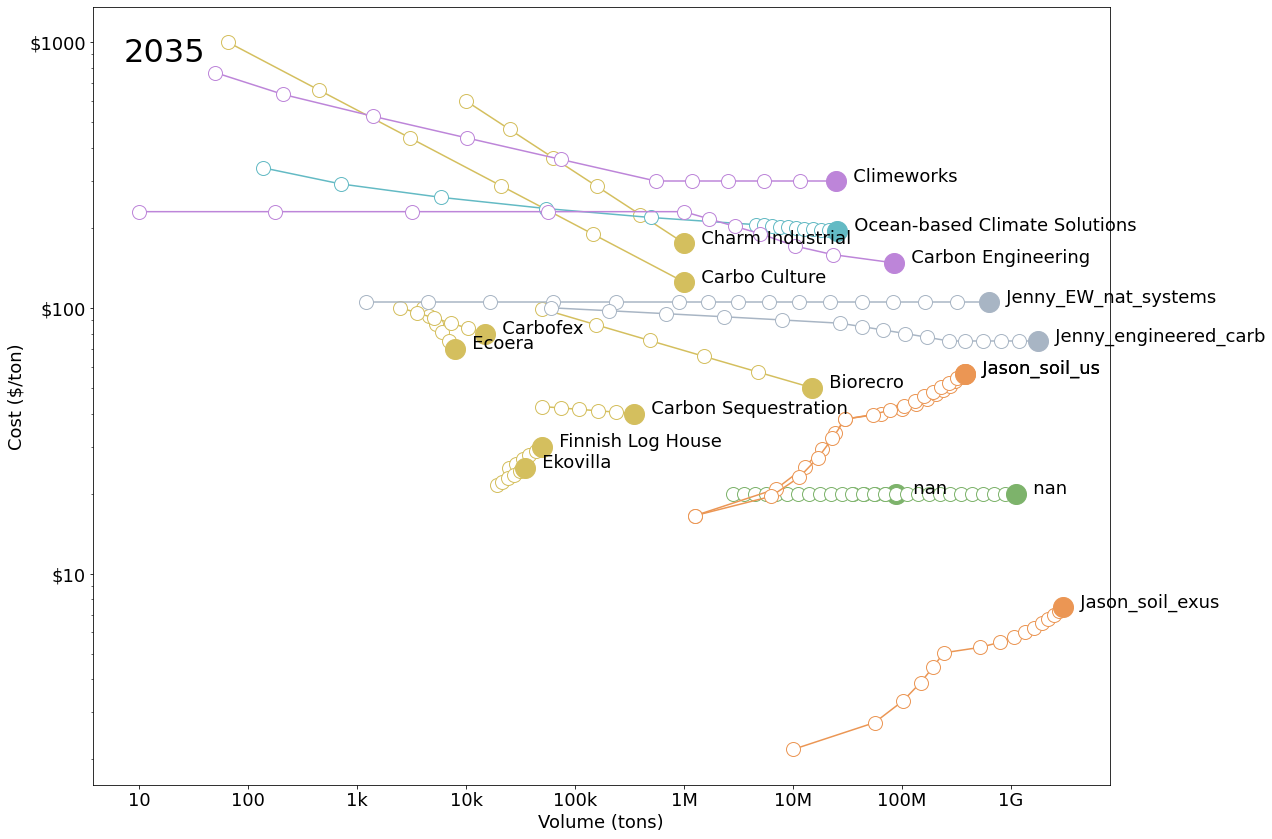

In [1345]:
# Expensive: generate each frame for animation. Aggregate version.
figsize(18,12)
sel = (df.valid_vc & sel_prefer_aggregate)
for year in range(first_year, last_year + 1):
    clf()
    plot_vc_to_time(df[sel], end=year, save_as='vol_cost_pt_ag_y%d' % year)

## Plot Individual Supply curves

In [601]:
#print('Sequestration types:')
#df.pt.unique()

In [602]:
#print('Sequestration types that have some cost data:')
#df[(df.cost_rating != -9999)].pt.unique()

In [603]:
#display_full(df[(df.cost_rating != -9999) & (df.pt == 'mineralization')].sort_values(by='cost_value'))

In [605]:
# Add private columns to store temporary data. May be used by functions as they wish
#def zero_priv():
#    df['_v'] = 0.0
#    df['_c'] = 0.0
#zero_priv()

In [673]:
# NEW

def plot_vcc_at_time(df_in, year=2020, logx=False, logy=False, save_as=None, ax=None):
    '''Plot data from first year to last year, highlighting last year.'''
    
    # Create a copy so we can add temp columns and sort
    df = df_in.copy()
    
    # Use average volume and cost for now
    df['vv'] = df.loc[:, ['vol_%d_min' % year, 'vol_%d_max' % year]].mean(axis=1)
    df['cc'] = df.loc[:, ['cost_%d_min' % year, 'cost_%d_max' % year]].mean(axis=1)
    
    # Sort from cheapest to most expensive
    df.sort_values(by='cc', inplace=True)
    
    df['vv_cumsum'] = df.vv.cumsum()
    
    # Deal with logx and logy
    min_y = 0 if not logy else 0.1

    last_vv_cumsum = 10.0
    for ii, proj in enumerate(df.itertuples()):
        #print('project is', type(project))
        #project = df.iloc[ii]
        clr = proj.clr
        vols = get_vols(project)
        costs = get_costs(project)
        
        # Just line
        #plot([last_vv_cumsum, proj.vv_cumsum], [proj.cc, proj.cc], '-', c=proj.clr, lw=2)
        
        # Left point
        plot([last_vv_cumsum], [proj.cc], 'o', c=proj.clr, ms=16)
        text(last_vv_cumsum, proj.cc, '  %s  ' % proj.applicant)

        # Right point
        #plot([proj.vv_cumsum], [proj.cc], 'o', c=proj.clr, ms=16)
        #text(proj.vv_cumsum, proj.cc, '%s  ' % proj.applicant, ha='right')

        # Fill below
        fill_between([last_vv_cumsum, proj.vv_cumsum], [proj.cc, proj.cc], color=proj.clr)
        
        last_vv_cumsum = proj.vv_cumsum
    annotate('%s' % year, xy=(.02, .93), xycoords='axes fraction', fontsize=32, va='top')
    xlabel('Cumulative Volume (tons)')
    ylabel('Cost ($/ton)')
    if logx: gca().set_xscale('log')
    if logy: gca().set_yscale('log')
    nice_vc_axes(skip_x=True)
    if ax: axis(ax)
    #tight_layout()
    if save_as:
        savefigs(save_as)

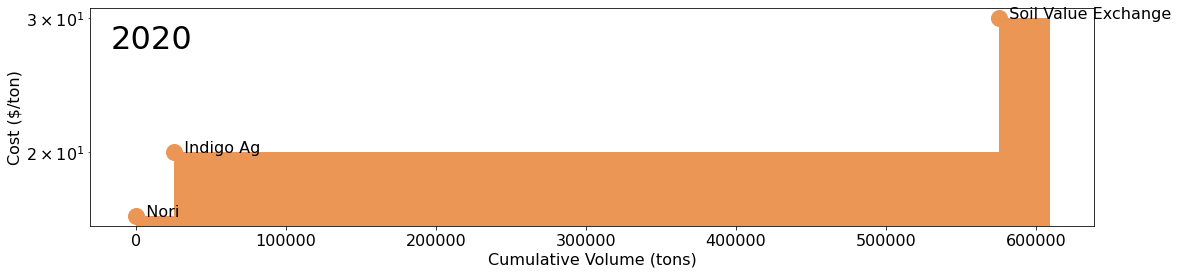

In [607]:
# Plot a single sector supply curve for 2020
figsize(18,4)
sel = (df.valid_vc & (df.projection_group == 'company') & (df.pt == 'soil'))
plot_vcc_at_time(df[sel], 2020, logx=False, logy=True)

In [ ]:
# Plot a single sector supply curve for the next three years
figsize(18,4)
sel = (df.valid_vc & (df.projection_group == 'company') & (df.pt == 'soil'))
plot_vcc_at_time(df[sel], 2022, logx=False, logy=True)
ax=axis(); clf()
print(ax)
plot_vcc_at_time(df[sel], 2020, logx=False, logy=True, ax=ax)
figure()
plot_vcc_at_time(df[sel], 2021, logx=False, logy=True, ax=ax)
figure()
plot_vcc_at_time(df[sel], 2022, logx=False, logy=True, ax=ax)

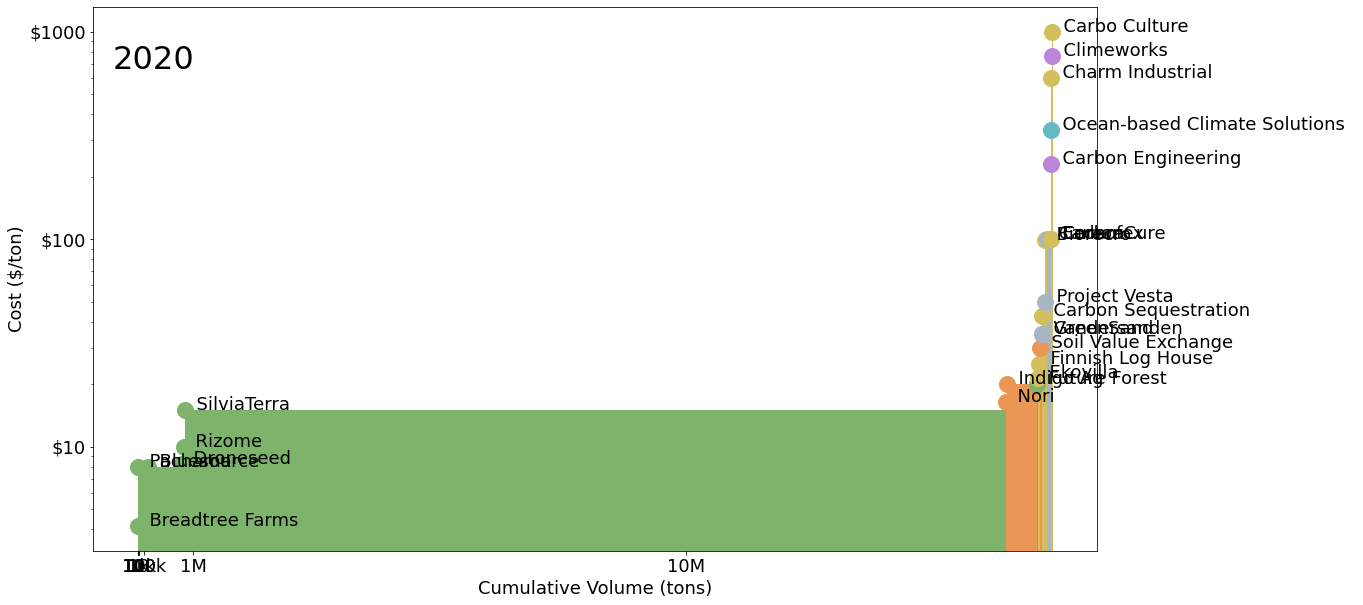

In [672]:
# Plot all sectors for 2020
figsize(18,10)
sel = (df.valid_vc & (df.projection_group == 'company'))
plot_vcc_at_time(df[sel], 2020, logx=False, logy=True)

In [629]:
# Plot all sectors for 2020 - 2035
# Expensive: generate each frame for animation
figsize(18,10)
sel = (df.valid_vc & (df.projection_group == 'company'))
# Plot and compute final axes
plot_vcc_at_time(df[sel], 2035, logx=False, logy=True)
ax = axis()
for year in range(first_year, last_year + 1):
    clf()
    plot_vcc_at_time(df[sel], year, logx=False, logy=True, save_as='vcc_y%d' % year, ax=ax)

ValueError: Format specifier missing precision

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1157295e0> (for post_execute):


ValueError: Format specifier missing precision

ValueError: Format specifier missing precision

<Figure size 1296x720 with 1 Axes>

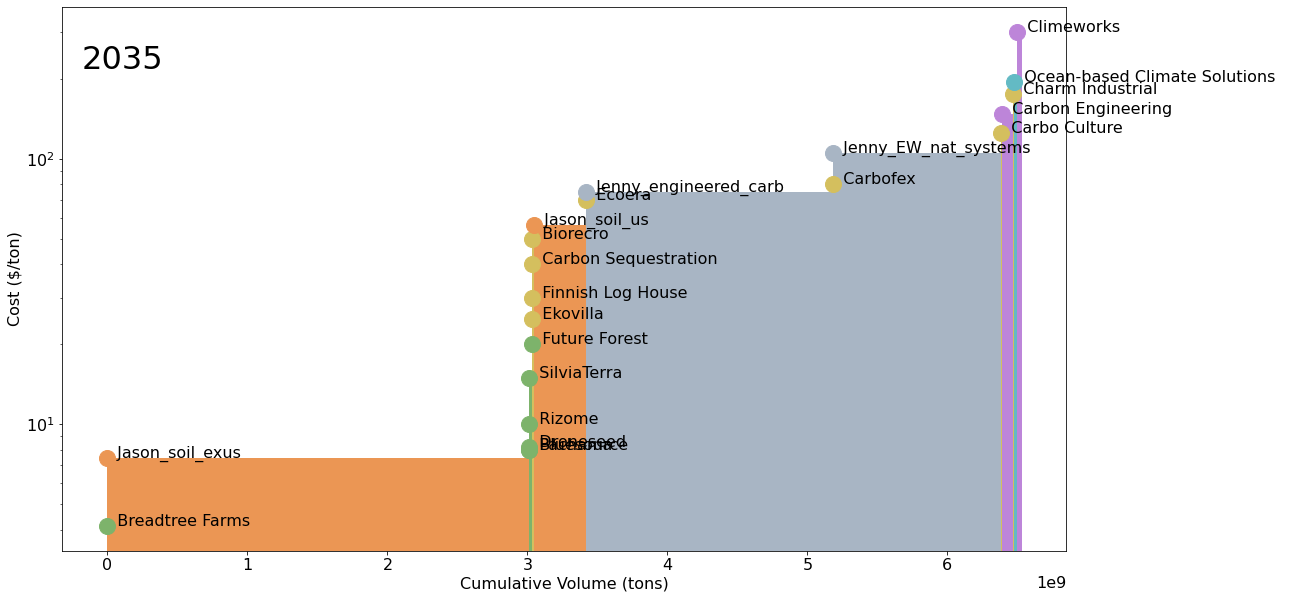

In [608]:
# Plot all sectors for 2020 - 2035, Aggregate version
# Expensive: generate each frame for animation
figsize(18,10)
sel = (df.valid_vc & sel_prefer_aggregate)
# Plot and compute final axes
plot_vcc_at_time(df[sel], 2035, logx=False, logy=True)
ax = axis()
for year in range(first_year, last_year + 1):
    clf()
    plot_vcc_at_time(df[sel], year, logx=False, logy=True, save_as='vcc_ag_y%d' % year, ax=ax)

In [ ]:
figsize(18,4)
df_filt = df[(df.cost_rating != -9999) & (df.pt == 'mineralization')]
plot_single_vol_cost_curve(df_filt, save_as='vol_cost_mineralization')

In [ ]:
figsize(18,12)
sel = (df.valid_vc & (df.projection_group == 'company'))
#plot_vc_to_time(df[sel], save_as='carbon_plan_vol_cost_pt')
plot_vc_to_time(df[sel], end=2020)

In [ ]:
for pt in primary_tags:
    if pt in df[(df.cost_rating != -9999)].pt.unique():
        df_filt = df[(df.cost_rating != -9999) & (df.pt == pt)]
        figure()
        plot_single_vol_cost_curve(df_filt, save_as='vol_cost_%s' % pt)

In [ ]:
for pt in df[(df.cost_rating != -9999)].pt.unique():
    df_filt = df[(df.cost_rating != -9999) & (df.pt == pt)]
    figure()
    plot_single_vol_cost_curve(df_filt, save_as='vol_cost_%s' % pt)

**Plot Combined Supply curves**

In [ ]:
def plot_vol_cost_curve(df, save_as=None, plot_legend=True):
    # Creates a sorted copy
    df = df.sort_values(by='cost_value')

    df['volume_cumsum'] = df.volume_value.cumsum()
    
    # Each entry is [vol, cost].
    # Separate curve for each primary tag
    pt_dat = {pt: DuckStruct(vc_list=[[0, 0]], clr=None) for pt in df.pt.unique()}
    
    for ii, project in enumerate(df.itertuples()):
        pt = project.pt
        duck = pt_dat[pt]
        duck.clr = project.clr
        vc = duck.vc_list

        left_vol = 0 if ii == 0 else df.volume_cumsum[ii-1]
        right_vol = project.volume_cumsum
        cost = project.cost_value
        print('ii is', ii, 'and adding left_vol and right vol', left_vol, right_vol)
        # Four points
        vc.append([left_vol, 0])
        vc.append([left_vol, cost])
        vc.append([right_vol, cost])
        vc.append([right_vol, 0])

    for pt, duck in pt_dat.items():
        duck.vc_arr = array(duck.vc_list)
        if pt == 'mineralization':
            #fill_between(duck.vc_arr[:,0], duck.vc_arr[:,1], color=duck.clr)
            print('plotting')
            plot(duck.vc_arr[:,0], duck.vc_arr[:,1], 'o-', color=duck.clr)
            display(duck.vc_arr)
            #display(duck.vc_arr[:,0].diff)
            return(duck)
    xlabel('Volume (tons)')
    ylabel('Cost ($/ton)')
    if plot_legend:
        legend((pt,), loc='upper left')
    tight_layout()
    ylim(bottom=0)
    if save_as:
        savefigs(save_as)
        

In [ ]:
df[(df.cost_rating != -9999)].pt.unique()

In [ ]:
figsize(18,6)
df_filt = df[(df.cost_rating != -9999)]
duck = plot_vol_cost_curve(df_filt)

# Scratch

In [1026]:
display_full(df.iloc[91:92])


,id,tags,description,applicant,rating,keywords,methods,revisions,location.name,source.name,source.license,source.url,documentation.name,documentation.url,mechanism_value,mechanism_units,mechanism_rating,mechanism_notes,mechanism_comment,volume_value,volume_units,volume_rating,volume_notes,volume_comment,negativity_value,negativity_units,negativity_rating,negativity_notes,negativity_comment,permanence_value,permanence_units,permanence_rating,permanence_notes,permanence_comment,additionality_value,additionality_units,additionality_rating,additionality_notes,additionality_comment,cost_value,cost_units,cost_rating,cost_notes,cost_comment,specificity_value,specificity_units,specificity_rating,specificity_notes,specificity_comment,pt,projection_comments,projection_group,cost_2020_min,cost_2021_min,cost_2022_min,cost_2023_min,cost_2024_min,cost_2025_min,cost_2026_min,cost_2027_min,cost_2028_min,cost_2029_min,cost_2030_min,cost_2031_min,cost_2032_min,cost_2033_min,cost_2034_min,cost_2035_min,cost_2020_max,cost_2021_max,cost_2022_max,cost_2023_max,cost_2024_max,cost_2025_max,cost_2026_max,cost_2027_max,cost_2028_max,cost_2029_max,cost_2030_max,cost_2031_max,cost_2032_max,cost_2033_max,cost_2034_max,cost_2035_max,vol_2020_min,vol_2021_min,vol_2022_min,vol_2023_min,vol_2024_min,vol_2025_min,vol_2026_min,vol_2027_min,vol_2028_min,vol_2029_min,vol_2030_min,vol_2031_min,vol_2032_min,vol_2033_min,vol_2034_min,vol_2035_min,vol_2020_max,vol_2021_max,vol_2022_max,vol_2023_max,vol_2024_max,vol_2025_max,vol_2026_max,vol_2027_max,vol_2028_max,vol_2029_max,vol_2030_max,vol_2031_max,vol_2032_max,vol_2033_max,vol_2034_max,vol_2035_max,valid_cost,valid_volume,valid_vc
91,MSFT156,"[forests, redd+]",Providing CDR from Costa Rica’s National REDD+ Program.,FONAFIFO,1.0,REDD+,NaN,"[{'date': '03-17-2021', 'note': 'First release.'}]",Costa Rica,Microsoft 2021 CDR RFP,NaN,https://app.powerbi.com/view?r=eyJrIjoiOGM2MGFlNGYtMGNlNy00YzY5LWEyMTAtOTA0ODEyNzEzYTczIiwidCI6ImMxMzZlZWMwLWZlOTItNDVlMC1iZWFlLTQ2OTg0OTczZTIzMiIsImMiOjF9,Website,https://www.fonafifo.go.cr/en/conozcanos/proyectos-actuales/,2.0,NaN,1.0,"Project removes carbon from atmosphere for storage in forests, and avoids emissions by discouraging deforestation and degradation.","A suite of government-led incentives pay private landowners to reduce emissions from deforestation and forest degradation, and enhance forest carbon stocks.",3519304.0,tCO₂,0.0,"Seller offers 3,519,304 tCO₂ removal attributed to Costa Rica's REDD+ activities in 2016 and 2017. The offered volume is just a portion of the total carbon benefits attributed to the project in these years. An 11% buffer pool is maintained to mitigate against reversals.","There is not enough information about the implementation of REDD+ activities to validate this volume. Seller claims to offer removal only. Since registries do not track removal and avoided emissions as separate types of carbon benefits, there is no way to validate that the removal slice of the project will not be sold again in the future.",NaN,NaN,0.0,NaN,There is not enough information to calculate or validate negativity.,15.0,years,1.0,"Seller claims 10,000 year permanence. We think this may be a typo.","Project activities as described pay landowners to protect forest, change forest management plans, pursue reforestation, assist natural regeneration, or transition to agroforestry. The minimum contract period for which landowners must maintain payed-for results is 15 years. We report this as the permanence.",0.0,NaN,NaN,No counterfactual is specified.,"Costa Rica's National Decarbonisation Plan aims for carbon neutrality by 2050. Seller claims that the sale of REDD+ carbon benefits will help Costa Rica reach its carbon neutrality goal by funding the expansion of program activities. Seller also indicates the intention to sell carbon benefits generated by the expansion of program activities. As an investment in a specific quantity of carbon removal, there are concerns about double-count

In [1028]:
# OLD
if False:
    # Fill in missing data with copies of old data until new data is encountered.
    for year in range(2021, 2036):
        prev_min = 'cost_%s_min' % (year - 1)
        this_min = 'cost_%s_min' % year
        sel = df.valid_vc & (df[this_min] == '')
        df.loc[sel, this_min] = df[sel][prev_min]

        prev_max = 'cost_%s_max' % (year - 1)
        this_max = 'cost_%s_max' % year
        sel = df.valid_vc & (df[this_max] == '')
        df.loc[sel, this_max] = df[sel][[this_min, prev_max]].max(axis=1)

        prev_min = 'vol_%s_min' % (year - 1)
        this_min = 'vol_%s_min' % year
        sel = df.valid_vc & (df[this_min] == '')
        df.loc[sel, this_min] = df[sel][prev_min]

        prev_max = 'vol_%s_max' % (year - 1)
        this_max = 'vol_%s_max' % year
        sel = df.valid_vc & (df[this_max] == '')
        df.loc[sel, this_max] = df[sel][[this_min, prev_max]].max(axis=1)

In [604]:
#OLD
def plot_single_vol_cost_curve(df, save_as=None, plot_legend=True):
    df = df.sort_values(by='cost_value')

    cv_cost = []
    cv_vol = []
    for ii, project in enumerate(df.itertuples()):
        # Left point
        cv_vol.append(0 if len(cv_vol) == 0 else cv_vol[-1])
        cv_cost.append(project.cost_value)
        # Right point
        cv_vol.append(cv_vol[-1] + project.volume_value)
        cv_cost.append(project.cost_value)    
        clr = project.clr
        pt = project.pt
    cv_cost = array(cv_cost)
    cv_vol = array(cv_vol)
    plot(cv_vol, cv_cost, 'o', mfc='w', mec=clr, ms=12)
    fill_between(cv_vol, cv_cost, color=clr)
    xlabel('Volume (tons)')
    ylabel('Cost ($/ton)')
    if plot_legend:
        legend((pt,), loc='upper left')
    tight_layout()
    ylim(bottom=0)
    if save_as:
        savefigs(save_as)